# FinTech Space 巴菲特選股策略範例

本策略分成以下兩部分：
- 運用 TejToolAPI 抓取巴菲特選股策略所需之財務面日資料，將資料進行清洗與篩選後，找出符合選股策略的標的。
- 運用 TQuant Lab 將標的進行買進持有一年 (2023-01-01 至 2023-12-31)，觀察其風險與報酬表現。

巴菲特 6 大選股條件如下：
1. 最近年度股東權益報酬率 ＞ 平均值 (市場及產業)
2. 3 年平均股東權益報酬率＞15%
3. 最近年度毛利率 ＞ 產業平均值
4. 7 年內市值增加值 / 7 年內保留盈餘增加值 > 1
5.  ( 最近年度自由現金流量 / 7 年前自由現金流量 ) - 1 > 1
6.  目前市值 / 未來 10 年自由現金流量折現值 < 1

## 設定基本套件與環境

``` python
os.environ['TEJAPI_KEY'] = tej_key    ==> 個人 api key 以驗證身分。
os.environ['TEJAPI_BASE'] = api_base  ==> 導航至 tej api 網域。
```

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# tej_key
tej_key = 'your key'
api_base = 'https://api.tej.com.tw'

os.environ['TEJAPI_KEY'] = tej_key 
os.environ['TEJAPI_BASE'] = api_base

## 使用 `get_universe()` 函式取得股票池
`get_universe()` 函數可以幫助我們抓取特定的股票池（市場、板塊、證券種類、產業）。  
比較每一元保留盈餘是否創造超過一元的市場價值時，由於牽涉到公司上市年限是否夠久，我們選取上市期間大於 7 年的公司。  
另外，因為 ROE 可以藉由舉債來提升，因此我們排除金融產業這類高槓桿的產業。

p.s. 關於 TQuant Lab 的說明，可參考 TQuant Lab github：[get_universe 說明](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/get_universe%E8%AA%AA%E6%98%8E.ipynb)

In [2]:
from zipline.sources.TEJ_Api_Data import get_universe

pool = get_universe(start = '2015-12-31', 
                    end = '2015-12-31',  # 選取 2015 年年底已上市的股票
                    mkt_bd_e = 'TSE',  # 已上市之股票
                    stktp_e = 'Common Stock',  # 普通股 
                    main_ind_e = 'General Industry') # general industry 篩掉金融產業
pool

['1101',
 '1102',
 '1103',
 '1104',
 '1108',
 '1109',
 '1110',
 '1201',
 '1203',
 '1210',
 '1213',
 '1215',
 '1216',
 '1217',
 '1218',
 '1219',
 '1220',
 '1225',
 '1227',
 '1229',
 '1231',
 '1232',
 '1233',
 '1234',
 '1235',
 '1236',
 '1301',
 '1303',
 '1304',
 '1305',
 '1307',
 '1308',
 '1309',
 '1310',
 '1312',
 '1313',
 '1314',
 '1315',
 '1316',
 '1319',
 '1321',
 '1323',
 '1324',
 '1325',
 '1326',
 '1339',
 '1402',
 '1409',
 '1410',
 '1413',
 '1414',
 '1416',
 '1417',
 '1418',
 '1419',
 '1423',
 '1432',
 '1434',
 '1435',
 '1436',
 '1437',
 '1438',
 '1439',
 '1440',
 '1441',
 '1442',
 '1443',
 '1444',
 '1445',
 '1446',
 '1447',
 '1449',
 '1451',
 '1452',
 '1453',
 '1454',
 '1455',
 '1456',
 '1457',
 '1459',
 '1460',
 '1463',
 '1464',
 '1465',
 '1466',
 '1467',
 '1468',
 '1469',
 '1470',
 '1471',
 '1472',
 '1473',
 '1474',
 '1475',
 '1476',
 '1477',
 '1503',
 '1504',
 '1506',
 '1507',
 '1512',
 '1513',
 '1514',
 '1515',
 '1516',
 '1517',
 '1519',
 '1521',
 '1522',
 '1524',
 '1525',
 

In [3]:
len(pool)

790

## 利用 TejToolAPI 抓取所需的財務資料
根據上述選股條件，我們需要的財務科目有以下 7 項：
1. 主產業別_中文
2. 常續ROE
3. 營業毛利率
4. 個股市值_元
5. 保留盈餘
6. 營運產生現金流量
7. 投資產生現金流量

註： 
- TejToolAPI 的詳細使用方法可參考 TQuant Lab github：[TejToolAPI 說明](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Data%20Preprocess%20-%20tejtoolapi.ipynb)
- TejToolAPI 提供之資料集可參考 TQuant Lab 官網：[TQuant Lab 資料集](https://tquant.tejwin.com/%e8%b3%87%e6%96%99%e9%9b%86/)

In [4]:
import TejToolAPI

start_time = pd.Timestamp('2015-12-31')
end_time = pd.Timestamp('2022-12-30')  # 將時間字串轉換成時間格式

data = TejToolAPI.get_history_data(start = start_time,
                                   end = end_time,
                                   ticker = pool,
                                   fin_type = 'A', # 為累計資料，舉例來說，Q3累計：1月～9月的資料。
                                   columns = ['主產業別_中文', '常續ROE', '營業毛利率', '個股市值_元', '保留盈餘', '營運產生現金流量', '投資產生現金流量'],
                                   transfer_to_chinese = True)

data

,公司簡稱,目前狀態,主產業別_中文,個股市值_元,營業毛利率_A,投資產生現金流量_A,營運產生現金流量_A,保留盈餘_A,常續ROE_A
0,1101,2015-12-31,M1100 水泥工業,1.007964e+11,14.59,-8454575.0,16741123.0,44337361.0,2.46
1,1101,2016-01-04,M1100 水泥工業,9.655040e+10,14.59,-8454575.0,16741123.0,44337361.0,2.46
2,1101,2016-01-05,M1100 水泥工業,9.747344e+10,14.59,-8454575.0,16741123.0,44337361.0,2.46
3,1101,2016-01-06,M1100 水泥工業,9.618118e+10,14.59,-8454575.0,16741123.0,44337361.0,2.46
4,1101,2016-01-07,M1100 水泥工業,1.009810e+11,14.59,-8454575.0,16741123.0,44337361.0,2.46
...,...,...,...,...,...,...,...,...,...
1319027,9958,2022-12-26,M2000 鋼鐵工業,2.003257e+10,10.79,-2106045.0,1420042.0,1913701.0,4.35
1319028,9958,2022-12-27,M2000 鋼鐵工業,2.045088e+10,10.79,-2106045.0,1420042.0,1913701.0,4.35
1319029,9958,2022-12-28,M2000 鋼鐵工業,2.135723e+10,10.79,-2106045.0,1420042.0,1913701.0,4.35
1319030,9958,2022-12-29,M2000 鋼鐵工業,2.110160e+10,10.79,-2106045.0,1420042.0,1913701.0,4.35


## 資料清洗

In [5]:
na_data = data[data.isnull().T.any()]  # 取出有空值的資料
na_list = na_data['公司簡稱'].unique().tolist()  # 取出資料有空值的股票代碼
na_list

['3321', '4555', '4968', '6443', '6464', '8464']

利用 tejapi 觀察以上 6 檔股票的上市日期，可以發現皆在 2015 年底上市。所以 2016 年初時會有財務資料為空值的狀況。

In [6]:
import tejapi

tejapi.ApiConfig.api_key = tej_key
tejapi.ApiConfig.ignoretz = api_base

check = tejapi.get('TWN/APISTOCK',  # 證券屬性資料表
                  coid = na_list,
                  opts = {'columns':['coid', 'mdate', 'stk_name', 'tse_date']},
                  chinese_column_name = True,
                  paginate = True)
check

,公司簡稱,目前狀態,證券名稱,首次TSE上市日
None,,,,
0,3321,2024-01-01,同泰,2015-12-15
1,4555,2024-01-01,氣立,2015-10-27
2,4968,2024-01-01,立積,2015-11-13
3,6443,2024-01-01,元晶,2015-10-01
4,6464,2024-01-01,台數科,2015-12-16
5,8464,2024-01-01,億豐,2015-12-22


In [7]:
data_all = data[~data['公司簡稱'].isin(na_list)]# 移除na_list中的股票資料
#data_all = data
data_all['個股市值(千)'] = data_all['個股市值_元'] / 1000  # 將個股市值的單位改為(千)
data_all['自由現金流量'] = data_all['營運產生現金流量_A'] + data_all['投資產生現金流量_A']  # 計算自由現金流量 = 營運產生現金流量 + (-)投資產生現金流量
data_all.drop(columns = ['個股市值_元', '營運產生現金流量_A', '投資產生現金流量_A'], inplace = True)  # 移除欄位
data_all

,公司簡稱,目前狀態,主產業別_中文,營業毛利率_A,保留盈餘_A,常續ROE_A,個股市值(千),自由現金流量
0,1101,2015-12-31,M1100 水泥工業,14.59,44337361.0,2.46,100796401.0,8286548.0
1,1101,2016-01-04,M1100 水泥工業,14.59,44337361.0,2.46,96550399.0,8286548.0
2,1101,2016-01-05,M1100 水泥工業,14.59,44337361.0,2.46,97473443.0,8286548.0
3,1101,2016-01-06,M1100 水泥工業,14.59,44337361.0,2.46,96181181.0,8286548.0
4,1101,2016-01-07,M1100 水泥工業,14.59,44337361.0,2.46,100981010.0,8286548.0
...,...,...,...,...,...,...,...,...
1319027,9958,2022-12-26,M2000 鋼鐵工業,10.79,1913701.0,4.35,20032571.0,-686003.0
1319028,9958,2022-12-27,M2000 鋼鐵工業,10.79,1913701.0,4.35,20450885.0,-686003.0
1319029,9958,2022-12-28,M2000 鋼鐵工業,10.79,1913701.0,4.35,21357231.0,-686003.0
1319030,9958,2022-12-29,M2000 鋼鐵工業,10.79,1913701.0,4.35,21101595.0,-686003.0


## 選股條件 1：最近年度股東權益報酬率＞平均值(市場及產業)

In [8]:
data_last_1Y = data_all[data_all['目前狀態'] == '2022-12-30'].reset_index(drop = True)  # 取出最近年度(2022-12-30)的資料
data_last_1Y

,公司簡稱,目前狀態,主產業別_中文,營業毛利率_A,保留盈餘_A,常續ROE_A,個股市值(千),自由現金流量
0,1101,2022-12-30,M1100 水泥工業,5.55,64275022.0,-0.07,240805516.0,-7925014.0
1,1102,2022-12-30,M1100 水泥工業,14.83,114375109.0,5.60,145383030.0,13823534.0
2,1103,2022-12-30,M1100 水泥工業,3.44,10519038.0,-1.32,13481182.0,53554.0
3,1104,2022-12-30,M1100 水泥工業,18.49,12668336.0,5.10,14510124.0,583449.0
4,1108,2022-12-30,M1100 水泥工業,19.85,663291.0,6.30,4350934.0,-246216.0
...,...,...,...,...,...,...,...,...
740,9944,2022-12-30,M9900 其他,26.99,1946086.0,1.94,2231240.0,597193.0
741,9945,2022-12-30,M9900 其他,22.23,71628565.0,22.26,136680817.0,-791032.0
742,9946,2022-12-30,M2500 建材營造,16.70,2907800.0,1.51,3983961.0,554326.0
743,9955,2022-12-30,M9900 其他,0.01,-551937.0,-5.44,2043523.0,-28051.0


In [9]:
ROE_1Y_data = data_last_1Y[['公司簡稱', '目前狀態', '主產業別_中文', '常續ROE_A']]  # 取出股票基本資料與 ROE 資料方便觀察。 
ROE_1Y_data

,公司簡稱,目前狀態,主產業別_中文,常續ROE_A
0,1101,2022-12-30,M1100 水泥工業,-0.07
1,1102,2022-12-30,M1100 水泥工業,5.60
2,1103,2022-12-30,M1100 水泥工業,-1.32
3,1104,2022-12-30,M1100 水泥工業,5.10
4,1108,2022-12-30,M1100 水泥工業,6.30
...,...,...,...,...
740,9944,2022-12-30,M9900 其他,1.94
741,9945,2022-12-30,M9900 其他,22.26
742,9946,2022-12-30,M2500 建材營造,1.51
743,9955,2022-12-30,M9900 其他,-5.44


In [10]:
industry_ROE_ave = ROE_1Y_data.groupby('主產業別_中文')['常續ROE_A'].transform('mean')  # 依不同產業分類，計算出產業平均 ROE
ROE_1Y_data['產業平均ROE'] = industry_ROE_ave  # 加入 '產業平均ROE' 欄位
 
ROE_1Y_data

,公司簡稱,目前狀態,主產業別_中文,常續ROE_A,產業平均ROE
0,1101,2022-12-30,M1100 水泥工業,-0.07,2.777143
1,1102,2022-12-30,M1100 水泥工業,5.60,2.777143
2,1103,2022-12-30,M1100 水泥工業,-1.32,2.777143
3,1104,2022-12-30,M1100 水泥工業,5.10,2.777143
4,1108,2022-12-30,M1100 水泥工業,6.30,2.777143
...,...,...,...,...,...
740,9944,2022-12-30,M9900 其他,1.94,7.404400
741,9945,2022-12-30,M9900 其他,22.26,7.404400
742,9946,2022-12-30,M2500 建材營造,1.51,6.178400
743,9955,2022-12-30,M9900 其他,-5.44,7.404400


In [11]:
set_1 = set(ROE_1Y_data[ROE_1Y_data['常續ROE_A'] > ROE_1Y_data['產業平均ROE']]['公司簡稱'])  # 篩選符合選股條件的公司
set_1

{'1102',
 '1104',
 '1108',
 '1109',
 '1201',
 '1203',
 '1215',
 '1216',
 '1218',
 '1219',
 '1225',
 '1227',
 '1229',
 '1231',
 '1232',
 '1301',
 '1303',
 '1307',
 '1308',
 '1309',
 '1315',
 '1319',
 '1323',
 '1339',
 '1402',
 '1409',
 '1410',
 '1413',
 '1435',
 '1436',
 '1438',
 '1439',
 '1440',
 '1443',
 '1444',
 '1451',
 '1452',
 '1454',
 '1464',
 '1465',
 '1468',
 '1470',
 '1473',
 '1474',
 '1475',
 '1476',
 '1477',
 '1503',
 '1513',
 '1514',
 '1516',
 '1517',
 '1519',
 '1521',
 '1522',
 '1524',
 '1525',
 '1526',
 '1527',
 '1530',
 '1535',
 '1536',
 '1537',
 '1539',
 '1540',
 '1541',
 '1558',
 '1560',
 '1568',
 '1583',
 '1604',
 '1605',
 '1614',
 '1615',
 '1707',
 '1708',
 '1709',
 '1712',
 '1713',
 '1717',
 '1720',
 '1723',
 '1730',
 '1733',
 '1762',
 '1773',
 '1783',
 '1817',
 '1904',
 '1905',
 '2006',
 '2012',
 '2013',
 '2015',
 '2020',
 '2025',
 '2027',
 '2028',
 '2030',
 '2034',
 '2049',
 '2059',
 '2062',
 '2103',
 '2105',
 '2106',
 '2108',
 '2109',
 '2114',
 '2206',
 '2227',
 

In [12]:
len(set_1)

364

## 選股條件 2：3年平均股東權益報酬率＞15%

In [13]:
data_last_3Y = data_all[data_all['目前狀態'].isin(['2022-12-30', '2021-12-30', '2020-12-30'])].reset_index(drop = True)
# 取出近三年(2022-12-30, 2021-12-30, 2020-12-30)的資料
data_last_3Y

,公司簡稱,目前狀態,主產業別_中文,營業毛利率_A,保留盈餘_A,常續ROE_A,個股市值(千),自由現金流量
0,1101,2020-12-30,M1100 水泥工業,33.09,67411710.0,9.26,250666148.0,-6479665.0
1,1101,2021-12-30,M1100 水泥工業,25.11,68643905.0,6.65,294011232.0,7480068.0
2,1101,2022-12-30,M1100 水泥工業,5.55,64275022.0,-0.07,240805516.0,-7925014.0
3,1102,2020-12-30,M1100 水泥工業,28.27,108794758.0,7.40,145046447.0,12079324.0
4,1102,2021-12-30,M1100 水泥工業,22.95,110746004.0,7.33,157068843.0,7316267.0
...,...,...,...,...,...,...,...,...
2246,9955,2021-12-30,M9900 其他,1.66,-450726.0,-4.33,1780342.0,-138428.0
2247,9955,2022-12-30,M9900 其他,0.01,-551937.0,-5.44,2043523.0,-28051.0
2248,9958,2020-12-30,M2000 鋼鐵工業,28.29,1493763.0,10.45,25005607.0,-1653632.0
2249,9958,2021-12-30,M2000 鋼鐵工業,25.32,2158648.0,11.63,25556313.0,-3917234.0


In [14]:
ROE_3Y_ave = data_last_3Y.groupby('公司簡稱')['常續ROE_A'].mean()  #計算公司三年平均的 ROE
ROE_3Y_ave = pd.DataFrame(ROE_3Y_ave).rename(columns = {'常續ROE_A': '3年平均ROE'})  # 從 Series 轉成 Dataframe，並重新命名欄位
ROE_3Y_ave

,3年平均ROE
公司簡稱,
1101,5.280000
1102,6.776667
1103,-2.246667
1104,3.960000
1108,5.650000
...,...
9944,1.683333
9945,14.920000
9946,2.293333


In [15]:
set_2 = set(ROE_3Y_ave[ROE_3Y_ave['3年平均ROE'] > 15].index)  # 篩選符合選股條件的公司
set_2

{'1232',
 '1309',
 '1325',
 '1476',
 '1477',
 '1526',
 '1537',
 '1541',
 '1707',
 '1773',
 '2028',
 '2059',
 '2108',
 '2327',
 '2330',
 '2345',
 '2348',
 '2368',
 '2376',
 '2377',
 '2379',
 '2383',
 '2385',
 '2395',
 '2404',
 '2454',
 '2455',
 '2458',
 '2465',
 '2467',
 '2480',
 '2505',
 '2546',
 '2597',
 '2603',
 '2609',
 '2615',
 '2905',
 '2912',
 '3006',
 '3014',
 '3017',
 '3023',
 '3030',
 '3034',
 '3037',
 '3042',
 '3048',
 '3130',
 '3209',
 '3413',
 '3443',
 '3515',
 '3533',
 '3557',
 '3669',
 '4536',
 '4952',
 '5234',
 '5269',
 '5434',
 '5471',
 '6202',
 '6278',
 '6281',
 '6409',
 '6412',
 '8016',
 '8046',
 '8081',
 '8112',
 '8210',
 '8261',
 '8341',
 '8422',
 '8454',
 '9906',
 '9910',
 '9914',
 '9917',
 '9921'}

In [16]:
len(set_2)

81

## 選股條件 3：最近年度毛利率＞產業平均值

In [17]:
GM_1Y_data = data_last_1Y[['公司簡稱', '目前狀態', '主產業別_中文', '營業毛利率_A']]  # 取出股票基本資料與 Gross Margin 資料方便觀察
GM_1Y_data

,公司簡稱,目前狀態,主產業別_中文,營業毛利率_A
0,1101,2022-12-30,M1100 水泥工業,5.55
1,1102,2022-12-30,M1100 水泥工業,14.83
2,1103,2022-12-30,M1100 水泥工業,3.44
3,1104,2022-12-30,M1100 水泥工業,18.49
4,1108,2022-12-30,M1100 水泥工業,19.85
...,...,...,...,...
740,9944,2022-12-30,M9900 其他,26.99
741,9945,2022-12-30,M9900 其他,22.23
742,9946,2022-12-30,M2500 建材營造,16.70
743,9955,2022-12-30,M9900 其他,0.01


In [18]:
industry_GM_ave = GM_1Y_data.groupby('主產業別_中文')['營業毛利率_A'].transform('mean')  # 依不同產業分類，計算出產業平均 GM
GM_1Y_data['產業毛利率平均'] = industry_GM_ave  # 加入 '產業毛利率平均' 欄位

GM_1Y_data

,公司簡稱,目前狀態,主產業別_中文,營業毛利率_A,產業毛利率平均
0,1101,2022-12-30,M1100 水泥工業,5.55,12.614286
1,1102,2022-12-30,M1100 水泥工業,14.83,12.614286
2,1103,2022-12-30,M1100 水泥工業,3.44,12.614286
3,1104,2022-12-30,M1100 水泥工業,18.49,12.614286
4,1108,2022-12-30,M1100 水泥工業,19.85,12.614286
...,...,...,...,...,...
740,9944,2022-12-30,M9900 其他,26.99,25.210600
741,9945,2022-12-30,M9900 其他,22.23,25.210600
742,9946,2022-12-30,M2500 建材營造,16.70,27.686800
743,9955,2022-12-30,M9900 其他,0.01,25.210600


In [19]:
set_3 = set(GM_1Y_data[GM_1Y_data['營業毛利率_A'] > GM_1Y_data['產業毛利率平均']]['公司簡稱'])  # 篩選符合選股條件的公司
set_3

{'1102',
 '1104',
 '1108',
 '1109',
 '1201',
 '1203',
 '1216',
 '1217',
 '1229',
 '1233',
 '1234',
 '1235',
 '1236',
 '1301',
 '1303',
 '1304',
 '1307',
 '1308',
 '1315',
 '1319',
 '1323',
 '1324',
 '1339',
 '1402',
 '1409',
 '1410',
 '1414',
 '1416',
 '1417',
 '1419',
 '1432',
 '1435',
 '1436',
 '1437',
 '1438',
 '1439',
 '1440',
 '1443',
 '1452',
 '1457',
 '1460',
 '1463',
 '1464',
 '1465',
 '1467',
 '1470',
 '1473',
 '1474',
 '1475',
 '1476',
 '1477',
 '1504',
 '1513',
 '1519',
 '1524',
 '1526',
 '1527',
 '1528',
 '1529',
 '1533',
 '1536',
 '1540',
 '1560',
 '1583',
 '1603',
 '1604',
 '1611',
 '1614',
 '1615',
 '1701',
 '1702',
 '1707',
 '1708',
 '1718',
 '1720',
 '1730',
 '1731',
 '1732',
 '1734',
 '1736',
 '1737',
 '1762',
 '1783',
 '1786',
 '1789',
 '1806',
 '1810',
 '1817',
 '1903',
 '2006',
 '2008',
 '2012',
 '2015',
 '2017',
 '2023',
 '2024',
 '2027',
 '2028',
 '2030',
 '2034',
 '2049',
 '2059',
 '2107',
 '2108',
 '2114',
 '2201',
 '2228',
 '2231',
 '2302',
 '2303',
 '2305',
 

In [20]:
len(set_3)

344

## 選股條件 4：7年內市值增加值 / 7年內保留盈餘增加值 > 1

In [21]:
MV_RE_data = data_all[data_all['目前狀態'].isin(['2015-12-31', '2022-12-30'])].reset_index(drop = True)  # 取出最近一年及七年前的資料
MV_RE_data = MV_RE_data[['公司簡稱', '目前狀態', '個股市值(千)', '保留盈餘_A']]  # 取出股票基本資料與市值、保留盈餘方便觀察。 
MV_RE_data

,公司簡稱,目前狀態,個股市值(千),保留盈餘_A
0,1101,2015-12-31,100796401.0,44337361.0
1,1101,2022-12-30,240805516.0,64275022.0
2,1102,2015-12-31,92103653.0,91900694.0
3,1102,2022-12-30,145383030.0,114375109.0
4,1103,2015-12-31,7375911.0,7756185.0
...,...,...,...,...
1524,9946,2022-12-30,3983961.0,2907800.0
1525,9955,2015-12-31,1295263.0,137930.0
1526,9955,2022-12-30,2043523.0,-551937.0
1527,9958,2015-12-31,1855581.0,369088.0


In [22]:
MV_RE_data['個股市值增加值'] = MV_RE_data.groupby('公司簡稱')['個股市值(千)'].diff()  # 計算個股市值增加值
MV_RE_data['保留盈餘增加值'] = MV_RE_data.groupby('公司簡稱')['保留盈餘_A'].diff()  # 計算保留盈餘增加值
MV_RE_data

,公司簡稱,目前狀態,個股市值(千),保留盈餘_A,個股市值增加值,保留盈餘增加值
0,1101,2015-12-31,100796401.0,44337361.0,NaN,NaN
1,1101,2022-12-30,240805516.0,64275022.0,140009115.0,19937661.0
2,1102,2015-12-31,92103653.0,91900694.0,NaN,NaN
3,1102,2022-12-30,145383030.0,114375109.0,53279377.0,22474415.0
4,1103,2015-12-31,7375911.0,7756185.0,NaN,NaN
...,...,...,...,...,...,...
1524,9946,2022-12-30,3983961.0,2907800.0,443286.0,1687667.0
1525,9955,2015-12-31,1295263.0,137930.0,NaN,NaN
1526,9955,2022-12-30,2043523.0,-551937.0,748260.0,-689867.0
1527,9958,2015-12-31,1855581.0,369088.0,NaN,NaN


In [23]:
MV_RE_data['指標'] = MV_RE_data['個股市值增加值'] / MV_RE_data['保留盈餘增加值']
MV_RE_data

,公司簡稱,目前狀態,個股市值(千),保留盈餘_A,個股市值增加值,保留盈餘增加值,指標
0,1101,2015-12-31,100796401.0,44337361.0,NaN,NaN,NaN
1,1101,2022-12-30,240805516.0,64275022.0,140009115.0,19937661.0,7.022344
2,1102,2015-12-31,92103653.0,91900694.0,NaN,NaN,NaN
3,1102,2022-12-30,145383030.0,114375109.0,53279377.0,22474415.0,2.370668
4,1103,2015-12-31,7375911.0,7756185.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1524,9946,2022-12-30,3983961.0,2907800.0,443286.0,1687667.0,0.262662
1525,9955,2015-12-31,1295263.0,137930.0,NaN,NaN,NaN
1526,9955,2022-12-30,2043523.0,-551937.0,748260.0,-689867.0,-1.084644
1527,9958,2015-12-31,1855581.0,369088.0,NaN,NaN,NaN


In [24]:
set_4 = set(MV_RE_data[MV_RE_data['指標'] > 1]['公司簡稱'])  # 篩選符合選股條件的公司
set_4

{'1101',
 '1102',
 '1103',
 '1110',
 '1203',
 '1210',
 '1213',
 '1215',
 '1216',
 '1217',
 '1218',
 '1219',
 '1220',
 '1225',
 '1229',
 '1231',
 '1232',
 '1233',
 '1235',
 '1304',
 '1305',
 '1308',
 '1309',
 '1313',
 '1314',
 '1316',
 '1321',
 '1324',
 '1402',
 '1409',
 '1414',
 '1417',
 '1423',
 '1432',
 '1435',
 '1436',
 '1437',
 '1438',
 '1439',
 '1440',
 '1453',
 '1454',
 '1457',
 '1459',
 '1460',
 '1466',
 '1467',
 '1468',
 '1473',
 '1474',
 '1475',
 '1476',
 '1477',
 '1503',
 '1513',
 '1514',
 '1515',
 '1517',
 '1519',
 '1524',
 '1526',
 '1528',
 '1533',
 '1540',
 '1560',
 '1568',
 '1603',
 '1604',
 '1605',
 '1608',
 '1609',
 '1611',
 '1614',
 '1615',
 '1617',
 '1618',
 '1701',
 '1708',
 '1709',
 '1710',
 '1712',
 '1713',
 '1714',
 '1720',
 '1721',
 '1725',
 '1727',
 '1730',
 '1731',
 '1732',
 '1734',
 '1735',
 '1736',
 '1762',
 '1773',
 '1783',
 '1786',
 '1802',
 '1808',
 '1810',
 '1904',
 '1907',
 '1909',
 '2002',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2012',
 '2013',
 

In [25]:
len(set_4)

442

## 選股條件 5：(最近年度自由現金流量 / 7年前自由現金流量) - 1 >= 1

In [26]:
cash_data = data_all[data_all['目前狀態'].isin(['2015-12-31', '2022-12-30'])].reset_index(drop = True)  # 取出最近一年及七年前的資料
cash_data = cash_data[['公司簡稱', '目前狀態', '自由現金流量']]  # 取出股票基本資料與自由現金流量方便觀察。
cash_data

,公司簡稱,目前狀態,自由現金流量
0,1101,2015-12-31,8286548.0
1,1101,2022-12-30,-7925014.0
2,1102,2015-12-31,9197717.0
3,1102,2022-12-30,13823534.0
4,1103,2015-12-31,-2602574.0
...,...,...,...
1524,9946,2022-12-30,554326.0
1525,9955,2015-12-31,-64874.0
1526,9955,2022-12-30,-28051.0
1527,9958,2015-12-31,243795.0


In [27]:
cash_data['自由現金流量比率'] = cash_data['自由現金流量'] / cash_data.groupby('公司簡稱')['自由現金流量'].shift(1)  # 計算自由現金流量比率
cash_data['指標'] = cash_data['自由現金流量比率'] - 1
cash_data

,公司簡稱,目前狀態,自由現金流量,自由現金流量比率,指標
0,1101,2015-12-31,8286548.0,NaN,NaN
1,1101,2022-12-30,-7925014.0,-0.956371,-1.956371
2,1102,2015-12-31,9197717.0,NaN,NaN
3,1102,2022-12-30,13823534.0,1.502931,0.502931
4,1103,2015-12-31,-2602574.0,NaN,NaN
...,...,...,...,...,...
1524,9946,2022-12-30,554326.0,0.548796,-0.451204
1525,9955,2015-12-31,-64874.0,NaN,NaN
1526,9955,2022-12-30,-28051.0,0.432392,-0.567608
1527,9958,2015-12-31,243795.0,NaN,NaN


In [28]:
set_5 = set(cash_data[cash_data['指標'] > 1]['公司簡稱'])  # 篩選符合選股條件的公司
set_5

{'1104',
 '1109',
 '1229',
 '1231',
 '1304',
 '1313',
 '1315',
 '1319',
 '1325',
 '1409',
 '1417',
 '1418',
 '1441',
 '1446',
 '1456',
 '1468',
 '1470',
 '1471',
 '1472',
 '1473',
 '1474',
 '1476',
 '1477',
 '1503',
 '1504',
 '1514',
 '1529',
 '1533',
 '1536',
 '1539',
 '1541',
 '1560',
 '1568',
 '1583',
 '1603',
 '1609',
 '1614',
 '1713',
 '1723',
 '1730',
 '1732',
 '1783',
 '1802',
 '1808',
 '1905',
 '1907',
 '2010',
 '2020',
 '2032',
 '2033',
 '2109',
 '2114',
 '2201',
 '2302',
 '2313',
 '2329',
 '2345',
 '2347',
 '2351',
 '2352',
 '2356',
 '2357',
 '2358',
 '2359',
 '2360',
 '2377',
 '2387',
 '2392',
 '2405',
 '2406',
 '2424',
 '2427',
 '2428',
 '2433',
 '2438',
 '2449',
 '2451',
 '2453',
 '2460',
 '2464',
 '2466',
 '2467',
 '2484',
 '2485',
 '2491',
 '2492',
 '2501',
 '2516',
 '2528',
 '2535',
 '2537',
 '2538',
 '2540',
 '2542',
 '2546',
 '2612',
 '2616',
 '2618',
 '2642',
 '2701',
 '2704',
 '2707',
 '2722',
 '2905',
 '2911',
 '3003',
 '3006',
 '3013',
 '3014',
 '3017',
 '3027',
 

In [29]:
len(set_5)

179

## 選股條件 6：目前市值 / 未來10年自由現金流量折現值 < 1

In [30]:
MV_cash_data = data_last_1Y[['公司簡稱', '目前狀態', '個股市值(千)', '自由現金流量']]  # 取出股票基本資料與自由現金流量方便觀察
MV_cash_data

,公司簡稱,目前狀態,個股市值(千),自由現金流量
0,1101,2022-12-30,240805516.0,-7925014.0
1,1102,2022-12-30,145383030.0,13823534.0
2,1103,2022-12-30,13481182.0,53554.0
3,1104,2022-12-30,14510124.0,583449.0
4,1108,2022-12-30,4350934.0,-246216.0
...,...,...,...,...
740,9944,2022-12-30,2231240.0,597193.0
741,9945,2022-12-30,136680817.0,-791032.0
742,9946,2022-12-30,3983961.0,554326.0
743,9955,2022-12-30,2043523.0,-28051.0


我們利用開源的模組 `numpy_financial` 來計算未來 10 年自由現金流量的折現值。  
在本範例中，我們使用二階段折現模型，第一階段(前3年)成長率預設為 15%，第二階段成長率為 5%、假設折現率為 9 %。  
以下先定義未來十年現金流量，y0 為 2022 的現金流量。

p.s. numpy_financial 的說明文件可參考： [numpy-financial documentation](https://numpy.org/numpy-financial/latest/)

In [31]:
import numpy_financial as npf

def Cashflows(y0):

    y1 = y0 * 1.15
    y2 = y1 * 1.15
    y3 = y2 * 1.15
    y4 = y3 * 1.05
    y5 = y4 * 1.05
    y6 = y5 * 1.05
    y7 = y6 * 1.05
    y8 = y7 * 1.05
    y9 = y8 * 1.05
    y10 = y9 * 1.05
    
    cashflows = np.array([y1,y2,y3,y4,y5,y6,y7,y8,y9,y10])
    
    return cashflows

In [32]:
MV_cash_data['指標'] = MV_cash_data['個股市值(千)'] / MV_cash_data['自由現金流量'].apply(lambda x: npf.npv(0.09, Cashflows(x)))
MV_cash_data

,公司簡稱,目前狀態,個股市值(千),自由現金流量,指標
0,1101,2022-12-30,240805516.0,-7925014.0,-2.669859
1,1102,2022-12-30,145383030.0,13823534.0,0.924095
2,1103,2022-12-30,13481182.0,53554.0,22.118619
3,1104,2022-12-30,14510124.0,583449.0,2.185195
4,1108,2022-12-30,4350934.0,-246216.0,-1.552702
...,...,...,...,...,...
740,9944,2022-12-30,2231240.0,597193.0,0.328287
741,9945,2022-12-30,136680817.0,-791032.0,-15.182226
742,9946,2022-12-30,3983961.0,554326.0,0.631498
743,9955,2022-12-30,2043523.0,-28051.0,-6.401078


In [33]:
set_6 = set(MV_cash_data[(MV_cash_data['指標'] < 1) & (MV_cash_data['指標'] > 0)]['公司簡稱'])  # 篩選符合選股條件的公司
set_6

{'1102',
 '1109',
 '1236',
 '1304',
 '1307',
 '1308',
 '1315',
 '1319',
 '1325',
 '1339',
 '1436',
 '1439',
 '1452',
 '1455',
 '1459',
 '1464',
 '1467',
 '1468',
 '1470',
 '1473',
 '1474',
 '1475',
 '1504',
 '1524',
 '1539',
 '1541',
 '1568',
 '1582',
 '1718',
 '1725',
 '1731',
 '1805',
 '1907',
 '2010',
 '2020',
 '2025',
 '2030',
 '2032',
 '2062',
 '2108',
 '2109',
 '2114',
 '2303',
 '2313',
 '2316',
 '2321',
 '2324',
 '2329',
 '2331',
 '2342',
 '2354',
 '2359',
 '2362',
 '2385',
 '2387',
 '2393',
 '2404',
 '2415',
 '2426',
 '2430',
 '2439',
 '2440',
 '2449',
 '2451',
 '2458',
 '2460',
 '2462',
 '2474',
 '2476',
 '2489',
 '2491',
 '2492',
 '2506',
 '2511',
 '2520',
 '2534',
 '2539',
 '2546',
 '2548',
 '2601',
 '2603',
 '2609',
 '2610',
 '2612',
 '2613',
 '2615',
 '2617',
 '2618',
 '2702',
 '2704',
 '3003',
 '3008',
 '3013',
 '3015',
 '3025',
 '3032',
 '3037',
 '3038',
 '3040',
 '3044',
 '3051',
 '3055',
 '3056',
 '3167',
 '3231',
 '3305',
 '3338',
 '3481',
 '3550',
 '3557',
 '3583',
 

In [34]:
len(set_6)

160

## 取出符合所有條件的股票

In [35]:
tickers = list(set_1 & set_2 & set_3 & set_4 & set_5 & set_6)
tickers

['3557', '8016', '6202', '9906']

## 整合每間公司符合哪些選股條件

In [36]:
company_list = data_all['公司簡稱'].unique().tolist()
coid = {'公司代碼': company_list}

data_combine = pd.DataFrame(coid)
data_combine['選股條件 1'] = data_combine['公司代碼'].isin(set_1)
data_combine['選股條件 2'] = data_combine['公司代碼'].isin(set_2)
data_combine['選股條件 3'] = data_combine['公司代碼'].isin(set_3)
data_combine['選股條件 4'] = data_combine['公司代碼'].isin(set_4)
data_combine['選股條件 5'] = data_combine['公司代碼'].isin(set_5)
data_combine['選股條件 6'] = data_combine['公司代碼'].isin(set_6)
data_combine['符合條件數量'] = data_combine.iloc[:, 1:7].sum(axis = 1)

data_combine

,公司代碼,選股條件 1,選股條件 2,選股條件 3,選股條件 4,選股條件 5,選股條件 6,符合條件數量
0,1101,False,False,False,True,False,False,1
1,1102,True,False,True,True,False,True,4
2,1103,False,False,False,True,False,False,1
3,1104,True,False,True,False,True,False,3
4,1108,True,False,True,False,False,False,2
...,...,...,...,...,...,...,...,...
779,9944,False,False,True,False,True,True,3
780,9945,True,False,False,True,False,False,2
781,9946,False,False,False,False,False,True,1
782,9955,False,False,False,False,False,False,0


## 利用 TQuant Lab 回測股票池買進持有 1 年的績效

### 導入股價資料
在 zipline 中，我們使用 `os` 搭配 `!zipline ingest` 將股價資料導入到本地端。常用寫法為:
``` python
!zipline ingest -b tqant
```
在 ingest 之前，需先使用 `os` 設定環境變數，
``` python
os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(tickers) + ' ' + 'IR0001'  
# IR0001 為加權股價報酬指數，通常用來當作回測 benchmark。
```

In [37]:
start = '2023-01-01'
end = '2023-12-31'

os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(tickers) + ' ' + 'IR0001'

!zipline ingest -b tquant

Merging daily equity files:


[2024-02-01 05:53:10.368880] INFO: zipline.data.bundles.core: Ingesting tquant.


### Initialize 函式

`initialize` 為構建 zipline 交易策略的重要函式，會在回測開始前被呼叫一次，主要任務為設定回測環境，常見用於設定滑價或手續費。  
zipline 提供四種滑價計算方法與三種手續費計算方法。於此範例中，我們使用 `VolumeShareSlippage` 計算滑價、`Custom_TW_Commission` 計算手續費。

註：
- 滑價設定方法可參考： TQuant Lab github：[zipline slippage model](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Zipline%20Slippage.ipynb)
- 手續費設定方法可參考： TQuant Lab github：[zipline commission model](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Zipline%20Commission%20Models.ipynb)

除此之外，我們可以注意到 initialize 含有一個參數 **context__**，**context__** 為一個命名空間 (namespace)，可以在儲存各種自定義之變數並且在每次交易日中循環呼叫。  
舉例來說，我們設置一個變數 (context.day = 0) 來計算交易日天數與一個變數 (context.tickers = tickers) 紀錄股票標的。

In [38]:
from zipline.api import *
from zipline.finance import commission, slippage

def initialize(context):
    context.day = 0
    context.tickers = tickers
    set_slippage(slippage.VolumeShareSlippage(volume_limit = 0.025, price_impact = 0.1))
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))
    set_benchmark(symbol('IR0001'))

### Handle_data 函式

`handle_data` 為構建 zipline 交易策略的重要函式，會在回測開始後每天被呼叫，主要任務為設定交易策略、下單與紀錄交易資訊。  
在此範例中，我們加入下單函式 `order_percent`，用以將資產均分購買股票池中的股票。 

註：
- `order_percent` 使用方法可參考： TQuant Lab github：[Zipline Order (percent & target_percent)](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Zipline%20Order%20(percent%20%26%20target_percent).ipynb)

In [39]:
def handle_data(context, data):

    # 回測第一天買進
    if context.day == 0:
        for ticker in context.tickers:
            order_percent(symbol(ticker), 1 / len(tickers))

    context.day += 1  # 以免重複買進

### Analyze 函式

`analyze` 主要用於回測後視覺化策略績效與風險，這裡我們以 `matplotlib` 繪製投組價值與大盤走勢的比較圖。  
其中 `analyze` 有兩個參數 **context** 與 **results**，**context** 就與上述相同，用以紀錄交易訊息，**results** 就是最終 ``run_algorithm`` 輸出的資料表 -- *results*。我們可以提取裡面特定欄位來繪製圖表。

In [40]:
import matplotlib.pyplot as plt

capital_base = 1e7  # 設定初始資金

def analyze(context, results):

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    results['benchmark_cum'] = results.benchmark_return.add(1).cumprod() * capital_base
    results[['portfolio_value', 'benchmark_cum']].plot(ax = ax1, label = 'Portfolio Value($)')
    ax1.set_ylabel('Portfolio value (TWD)')

    plt.legend(loc = 'upper left')

    plt.gcf().set_size_inches(18, 8)
    plt.grid()
    plt.show()

### Run_algorithm 函式

進行策略回測。

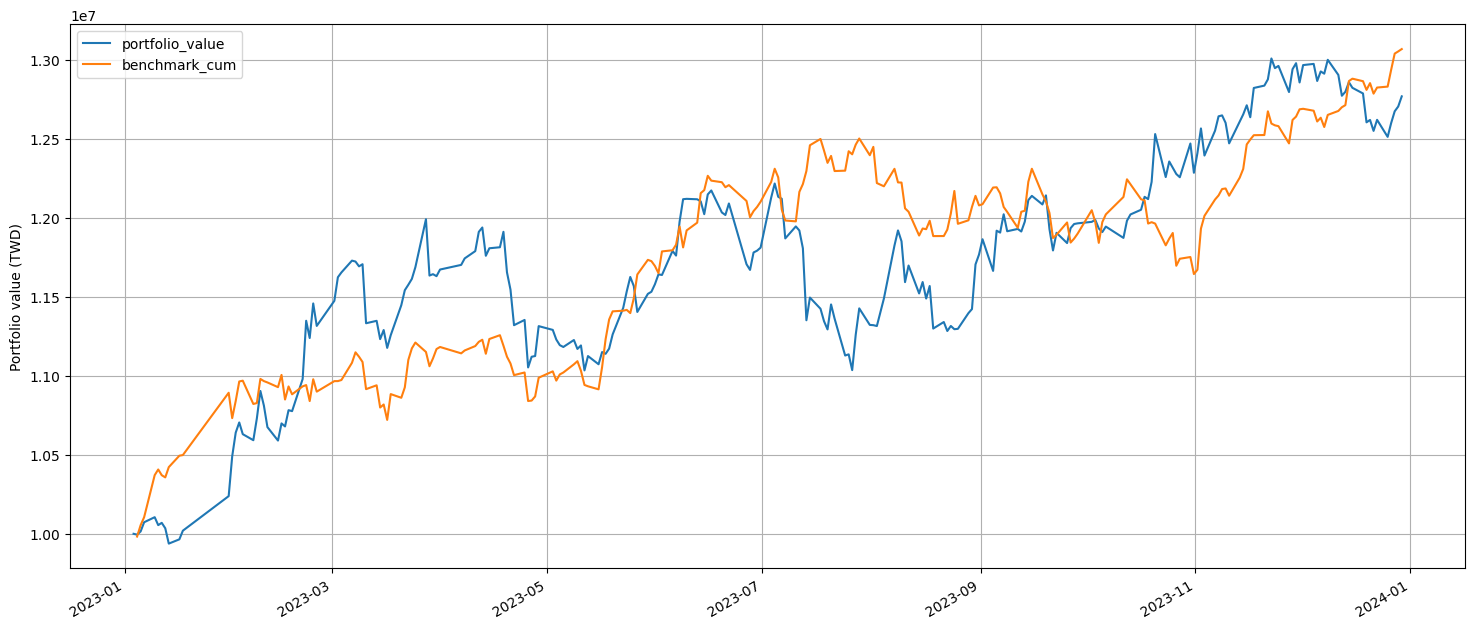

,period_open,period_close,starting_exposure,pnl,shorts_count,short_exposure,transactions,gross_leverage,starting_value,starting_cash,...,sharpe,treasury_period_return,max_drawdown,sortino,max_leverage,benchmark_period_return,excess_return,benchmark_volatility,algo_volatility,benchmark_cum
2023-01-03 13:30:00+08:00,2023-01-03 09:01:00+08:00,2023-01-03 13:30:00+08:00,0.00,0.000000,0,0.0,[],0.000000,0.00,1.000000e+07,...,NaN,0.0,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
2023-01-04 13:30:00+08:00,2023-01-04 09:01:00+08:00,2023-01-04 13:30:00+08:00,0.00,-5436.149082,0,0.0,"[{'amount': 800, 'dt': 2023-01-04 13:30:00+08:...",0.375105,0.00,1.000000e+07,...,-11.224972,0.0,-0.000544,-11.224972,0.375105,-0.001741,0.001197,NaN,0.006102,9.982590e+06
2023-01-05 13:30:00+08:00,2023-01-05 09:01:00+08:00,2023-01-05 13:30:00+08:00,3749007.50,20083.018818,0,0.0,"[{'amount': 650, 'dt': 2023-01-05 13:30:00+08:...",0.514344,3749007.50,6.245556e+06,...,5.767500,0.0,-0.000544,24.712511,0.514344,0.005424,-0.003960,0.100115,0.021348,1.005424e+07
2023-01-06 13:30:00+08:00,2023-01-06 09:01:00+08:00,2023-01-06 13:30:00+08:00,5150968.55,58509.691406,0,0.0,"[{'amount': 225, 'dt': 2023-01-06 13:30:00+08:...",0.521792,5150968.55,4.863678e+06,...,10.024164,0.0,-0.000544,106.705994,0.521792,0.010506,-0.003191,0.073959,0.045931,1.010506e+07
2023-01-09 13:30:00+08:00,2023-01-09 09:01:00+08:00,2023-01-09 13:30:00+08:00,5256089.65,31959.302656,0,0.0,"[{'amount': 550, 'dt': 2023-01-09 13:30:00+08:...",0.532339,5256089.65,4.817067e+06,...,12.912758,0.0,-0.000544,136.874624,0.532339,0.037143,-0.026631,0.191248,0.040908,1.037143e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 13:30:00+08:00,2023-12-25 09:01:00+08:00,2023-12-25 13:30:00+08:00,12017048.20,-107858.700000,0,0.0,[],0.951775,12017048.20,6.034204e+05,...,1.465825,0.0,-0.096677,2.129799,1.030426,0.283076,-0.031815,0.126110,0.174407,1.283076e+07
2023-12-26 13:30:00+08:00,2023-12-26 09:01:00+08:00,2023-12-26 13:30:00+08:00,11909189.50,87819.600000,0,0.0,[],0.952111,11909189.50,6.034204e+05,...,1.504835,0.0,-0.096677,2.187849,1.030426,0.293786,-0.033743,0.126064,0.174146,1.293786e+07
2023-12-27 13:30:00+08:00,2023-12-27 09:01:00+08:00,2023-12-27 13:30:00+08:00,11997009.10,74001.800000,0,0.0,[],0.952391,11997009.10,6.034204e+05,...,1.536974,0.0,-0.096677,2.235473,1.030426,0.303973,-0.036530,0.125989,0.173848,1.303973e+07
2023-12-28 13:30:00+08:00,2023-12-28 09:01:00+08:00,2023-12-28 13:30:00+08:00,12071010.90,30398.300000,0,0.0,[],0.952505,12071010.90,6.034204e+05,...,1.548345,0.0,-0.096677,2.252062,1.030426,0.305349,-0.034866,0.125721,0.173486,1.305349e+07


In [41]:
from zipline import run_algorithm
from zipline.utils.run_algo import get_transaction_detail

start_date = pd.Timestamp(start, tz = 'utc')
end_date = pd.Timestamp(end, tz = 'utc')  # 轉換成時間序列格式

results = run_algorithm(
    start = start_date,
    end = end_date,
    initialize = initialize,
    handle_data = handle_data,
    analyze = analyze,
    bundle = 'tquant',
    capital_base = capital_base,
)

# 取出 results 中的 positions, transactions & orders 資料表
positions, transactions, orders = get_transaction_detail(results)   
results

<AxesSubplot:>

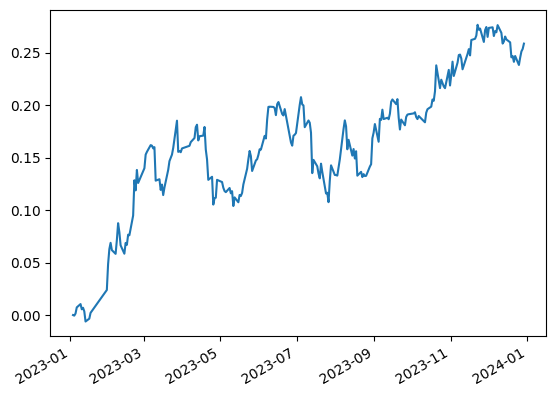

In [42]:
results.returns.cumsum().plot()  # 繪製累積回報圖

### 查看 positions, transactions & orders 資料表

In [43]:
positions

,sid,symbol,asset,amount,cost_basis,last_sale_price
2023-01-04 13:30:00+08:00,0,3557,Equity(0 [3557]),800,49.274325,49.2
2023-01-04 13:30:00+08:00,2,8016,Equity(2 [8016]),13477,185.264574,185.0
2023-01-04 13:30:00+08:00,1,6202,Equity(1 [6202]),17100,69.102675,69.0
2023-01-04 13:30:00+08:00,3,9906,Equity(3 [9906]),775,47.171331,47.1
2023-01-05 13:30:00+08:00,0,3557,Equity(0 [3557]),1450,49.184449,49.0
...,...,...,...,...,...,...
2023-12-28 13:30:00+08:00,3,9906,Equity(3 [9906]),53418,50.534527,55.0
2023-12-29 13:30:00+08:00,0,3557,Equity(0 [3557]),50864,52.066406,60.1
2023-12-29 13:30:00+08:00,2,8016,Equity(2 [8016]),13477,185.264574,278.0
2023-12-29 13:30:00+08:00,1,6202,Equity(1 [6202]),36023,69.154644,66.7


In [44]:
transactions

,sid,symbol,amount,dt,price,order_id,asset,commission
2023-01-04 13:30:00+08:00,0,3557,800,2023-01-04 13:30:00+08:00,49.203075,634d0ecb1fcf4cdf8665fc72565afc61,Equity(0 [3557]),None
2023-01-04 13:30:00+08:00,2,8016,13477,2023-01-04 13:30:00+08:00,185.000940,a6309ffd6e0b4b6782fc79f228674976,Equity(2 [8016]),None
2023-01-04 13:30:00+08:00,1,6202,17100,2023-01-04 13:30:00+08:00,69.004312,33d43c06107a49fa81d82782e8aa50b0,Equity(1 [6202]),None
2023-01-04 13:30:00+08:00,3,9906,775,2023-01-04 13:30:00+08:00,47.102944,089a9f6e919747299dcc163d8de413d4,Equity(3 [9906]),None
2023-01-05 13:30:00+08:00,0,3557,650,2023-01-05 13:30:00+08:00,49.003062,634d0ecb1fcf4cdf8665fc72565afc61,Equity(0 [3557]),None
...,...,...,...,...,...,...,...,...
2023-03-29 13:30:00+08:00,3,9906,2650,2023-03-29 13:30:00+08:00,51.703231,089a9f6e919747299dcc163d8de413d4,Equity(3 [9906]),None
2023-03-30 13:30:00+08:00,3,9906,1525,2023-03-30 13:30:00+08:00,51.603225,089a9f6e919747299dcc163d8de413d4,Equity(3 [9906]),None
2023-03-31 13:30:00+08:00,3,9906,1125,2023-03-31 13:30:00+08:00,52.203263,089a9f6e919747299dcc163d8de413d4,Equity(3 [9906]),None
2023-04-06 13:30:00+08:00,3,9906,425,2023-04-06 13:30:00+08:00,52.303269,089a9f6e919747299dcc163d8de413d4,Equity(3 [9906]),None


In [45]:
orders

,sid,symbol,id,dt,reason,created,amount,filled,commission,stop,limit,stop_reached,limit_reached,asset,status
2023-01-03 13:30:00+08:00,0,3557,634d0ecb1fcf4cdf8665fc72565afc61,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,50864,0,0.0,None,None,False,False,Equity(0 [3557]),0
2023-01-03 13:30:00+08:00,2,8016,a6309ffd6e0b4b6782fc79f228674976,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,13477,0,0.0,None,None,False,False,Equity(2 [8016]),0
2023-01-03 13:30:00+08:00,1,6202,33d43c06107a49fa81d82782e8aa50b0,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,36023,0,0.0,None,None,False,False,Equity(1 [6202]),0
2023-01-03 13:30:00+08:00,3,9906,089a9f6e919747299dcc163d8de413d4,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,53418,0,0.0,None,None,False,False,Equity(3 [9906]),0
2023-01-04 13:30:00+08:00,0,3557,634d0ecb1fcf4cdf8665fc72565afc61,2023-01-04 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,50864,800,57.0,None,None,False,False,Equity(0 [3557]),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-29 13:30:00+08:00,3,9906,089a9f6e919747299dcc163d8de413d4,2023-03-29 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,53418,49575,3613.0,None,None,False,False,Equity(3 [9906]),0
2023-03-30 13:30:00+08:00,3,9906,089a9f6e919747299dcc163d8de413d4,2023-03-30 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,53418,51100,3726.0,None,None,False,False,Equity(3 [9906]),0
2023-03-31 13:30:00+08:00,3,9906,089a9f6e919747299dcc163d8de413d4,2023-03-31 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,53418,52225,3810.0,None,None,False,False,Equity(3 [9906]),0
2023-04-06 13:30:00+08:00,3,9906,089a9f6e919747299dcc163d8de413d4,2023-04-06 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,53418,52650,3842.0,None,None,False,False,Equity(3 [9906]),0


In [46]:
orders[orders['symbol'] == '3557']

,sid,symbol,id,dt,reason,created,amount,filled,commission,stop,limit,stop_reached,limit_reached,asset,status
2023-01-03 13:30:00+08:00,0,3557,634d0ecb1fcf4cdf8665fc72565afc61,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,50864,0,0.0,None,None,False,False,Equity(0 [3557]),0
2023-01-04 13:30:00+08:00,0,3557,634d0ecb1fcf4cdf8665fc72565afc61,2023-01-04 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,50864,800,57.0,None,None,False,False,Equity(0 [3557]),0
2023-01-05 13:30:00+08:00,0,3557,634d0ecb1fcf4cdf8665fc72565afc61,2023-01-05 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,50864,1450,103.0,None,None,False,False,Equity(0 [3557]),0
2023-01-06 13:30:00+08:00,0,3557,634d0ecb1fcf4cdf8665fc72565afc61,2023-01-06 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,50864,1675,123.0,None,None,False,False,Equity(0 [3557]),0
2023-01-09 13:30:00+08:00,0,3557,634d0ecb1fcf4cdf8665fc72565afc61,2023-01-09 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,50864,2225,162.0,None,None,False,False,Equity(0 [3557]),0
2023-01-10 13:30:00+08:00,0,3557,634d0ecb1fcf4cdf8665fc72565afc61,2023-01-10 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,50864,10825,806.0,None,None,False,False,Equity(0 [3557]),0
2023-01-11 13:30:00+08:00,0,3557,634d0ecb1fcf4cdf8665fc72565afc61,2023-01-11 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,50864,17175,1274.0,None,None,False,False,Equity(0 [3557]),0
2023-01-12 13:30:00+08:00,0,3557,634d0ecb1fcf4cdf8665fc72565afc61,2023-01-12 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,50864,21050,1551.0,None,None,False,False,Equity(0 [3557]),0
2023-01-13 13:30:00+08:00,0,3557,634d0ecb1fcf4cdf8665fc72565afc61,2023-01-13 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,50864,22150,1630.0,None,None,False,False,Equity(0 [3557]),0
2023-01-16 13:30:00+08:00,0,3557,634d0ecb1fcf4cdf8665fc72565afc61,2023-01-16 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,50864,23375,1718.0,None,None,False,False,Equity(0 [3557]),0


In [47]:
orders.loc['2023-01-03']

,sid,symbol,id,dt,reason,created,amount,filled,commission,stop,limit,stop_reached,limit_reached,asset,status
2023-01-03 13:30:00+08:00,0,3557,634d0ecb1fcf4cdf8665fc72565afc61,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,50864,0,0.0,None,None,False,False,Equity(0 [3557]),0
2023-01-03 13:30:00+08:00,2,8016,a6309ffd6e0b4b6782fc79f228674976,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,13477,0,0.0,None,None,False,False,Equity(2 [8016]),0
2023-01-03 13:30:00+08:00,1,6202,33d43c06107a49fa81d82782e8aa50b0,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,36023,0,0.0,None,None,False,False,Equity(1 [6202]),0
2023-01-03 13:30:00+08:00,3,9906,089a9f6e919747299dcc163d8de413d4,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,53418,0,0.0,None,None,False,False,Equity(3 [9906]),0


## Pyfolio

Pyfolio 與 zipline 的回測結果兼容，讓我們輕鬆用幾行程式碼，就能產出我們需要的投資風險及績效圖表。

p.s. 詳細 Pyfolio 使用方法可參考： TQuant Lab github：[Pyfolio](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Pyfolio.ipynb)

In [48]:
from pyfolio.utils import extract_rets_pos_txn_from_zipline
import pyfolio

returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)  # 從 results 資料表中取出 returns, positions & transactions
benchmark_rets = results.benchmark_return  # 取出 benchmark 的報酬率

<AxesSubplot:title={'center':'Rolling Sharpe ratio (6-month)'}, ylabel='Sharpe ratio'>

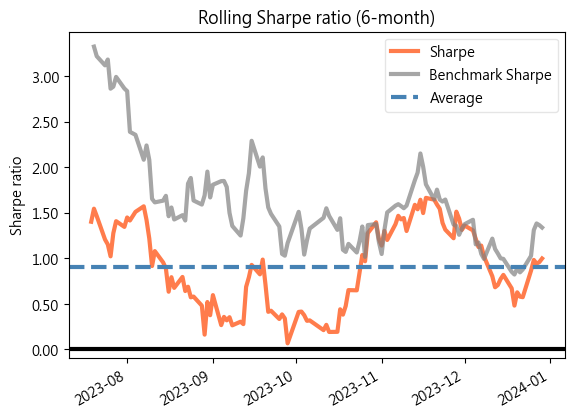

In [49]:
# 繪製夏普比率圖

from pyfolio.plotting import plot_rolling_sharpe

plot_rolling_sharpe(returns,
                    factor_returns=benchmark_rets)

Start date,2023-01-03
End date,2023-12-29
Total months,11
,Backtest
Annual return,29.4%
Cumulative returns,27.69%
Annual volatility,17.317%
Sharpe ratio,1.58
Calmar ratio,3.04
Stability,0.69
Max drawdown,-9.668%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.67,2023-07-04,2023-07-26,2023-10-19,74
1,7.98,2023-03-27,2023-05-11,2023-06-08,50
2,4.71,2023-03-06,2023-03-16,2023-03-27,16
3,4.13,2023-06-16,2023-06-27,2023-07-04,11
4,3.81,2023-11-22,2023-12-25,NaT,NaN


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


Stress Events,mean,min,max
New Normal,0.11%,-3.86%,3.36%


Top 10 long positions of all time,max
sid,
8016,33.58%
3557,32.28%
9906,28.59%
6202,26.01%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
8016,33.58%
3557,32.28%
9906,28.59%
6202,26.01%


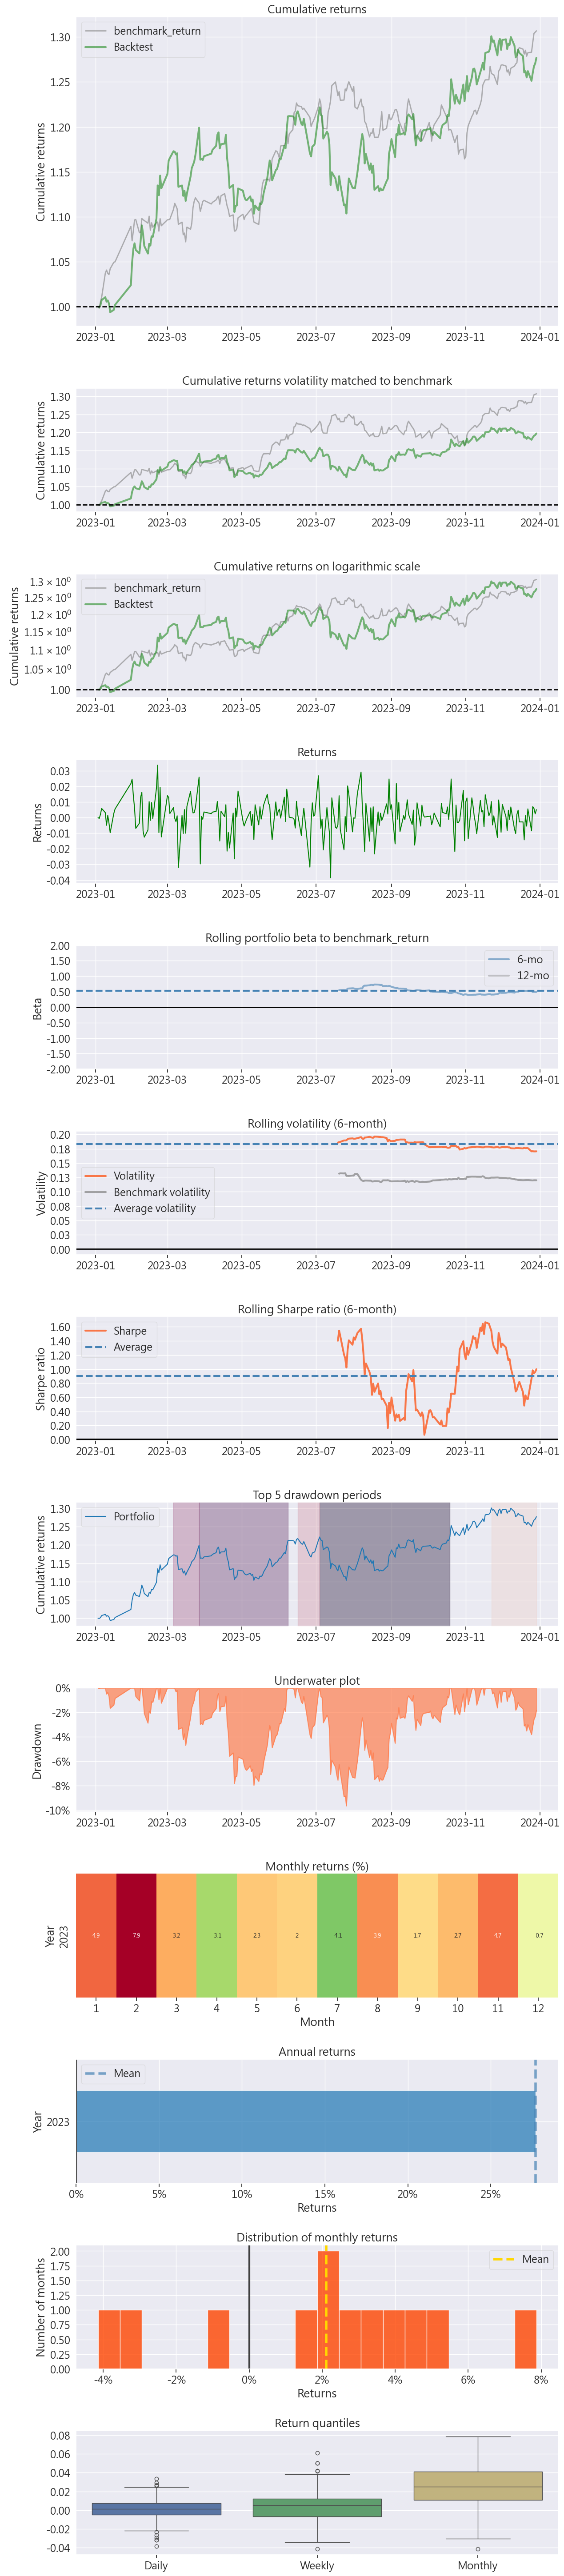

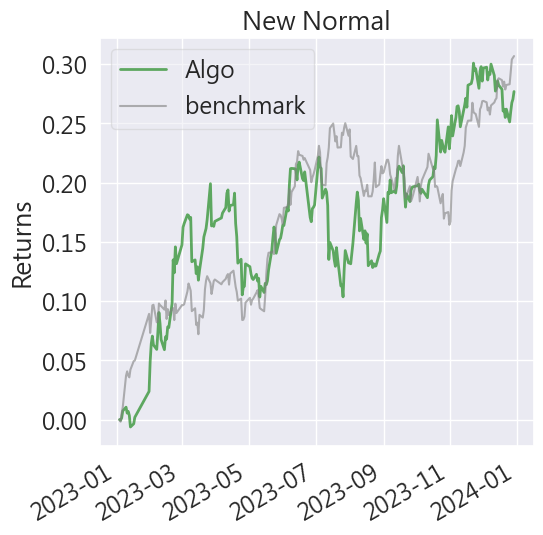

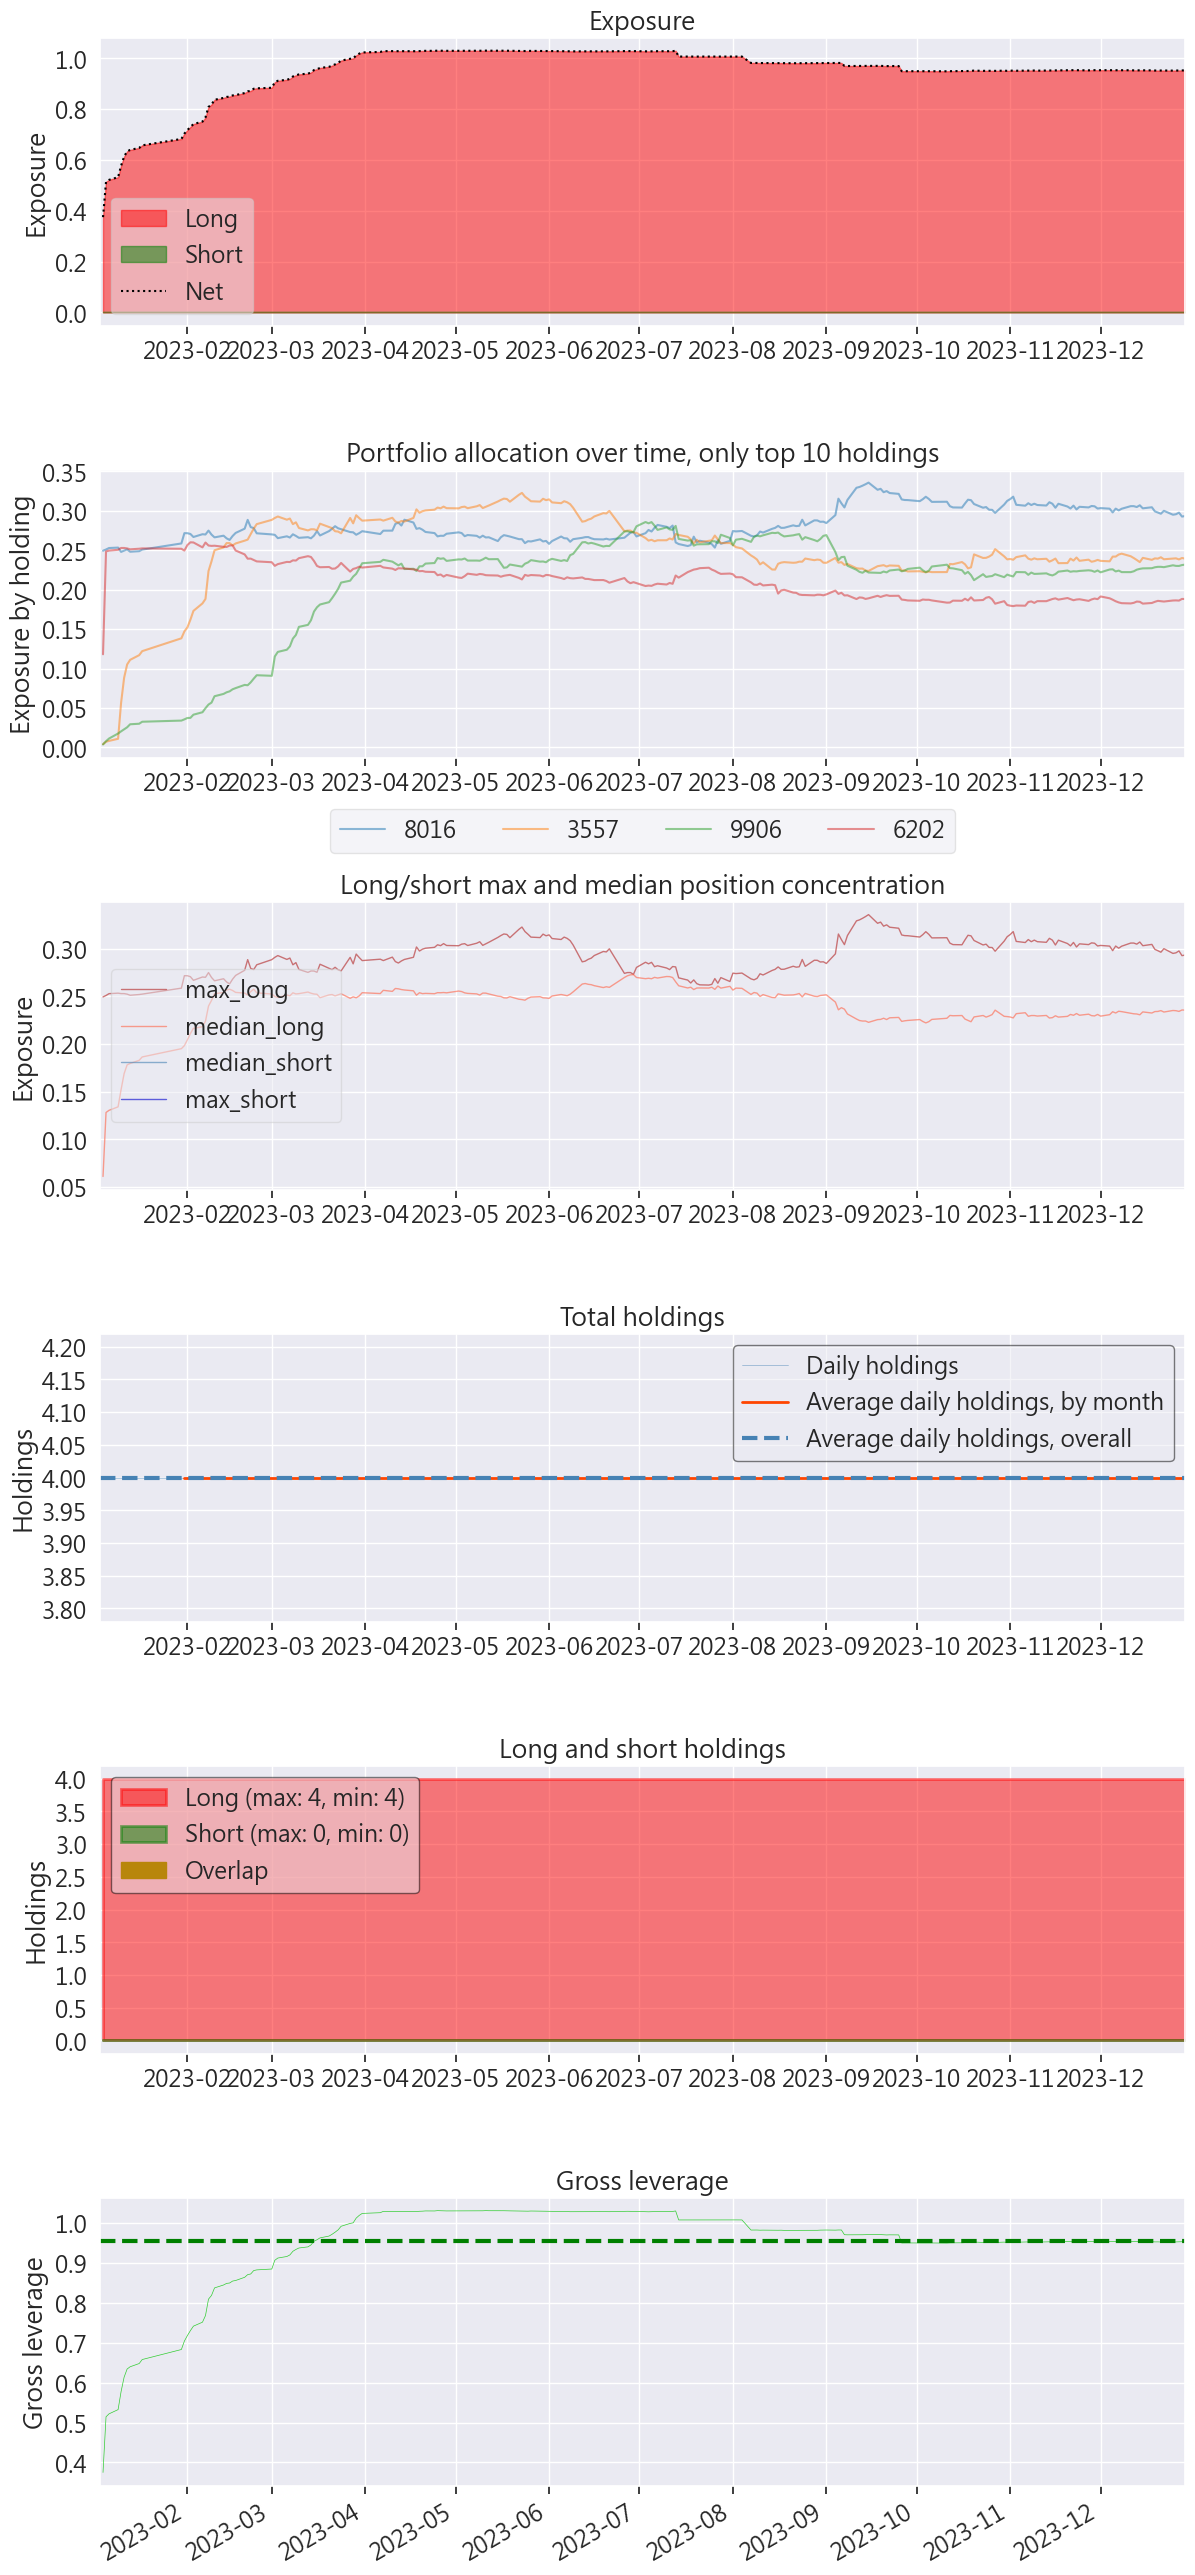

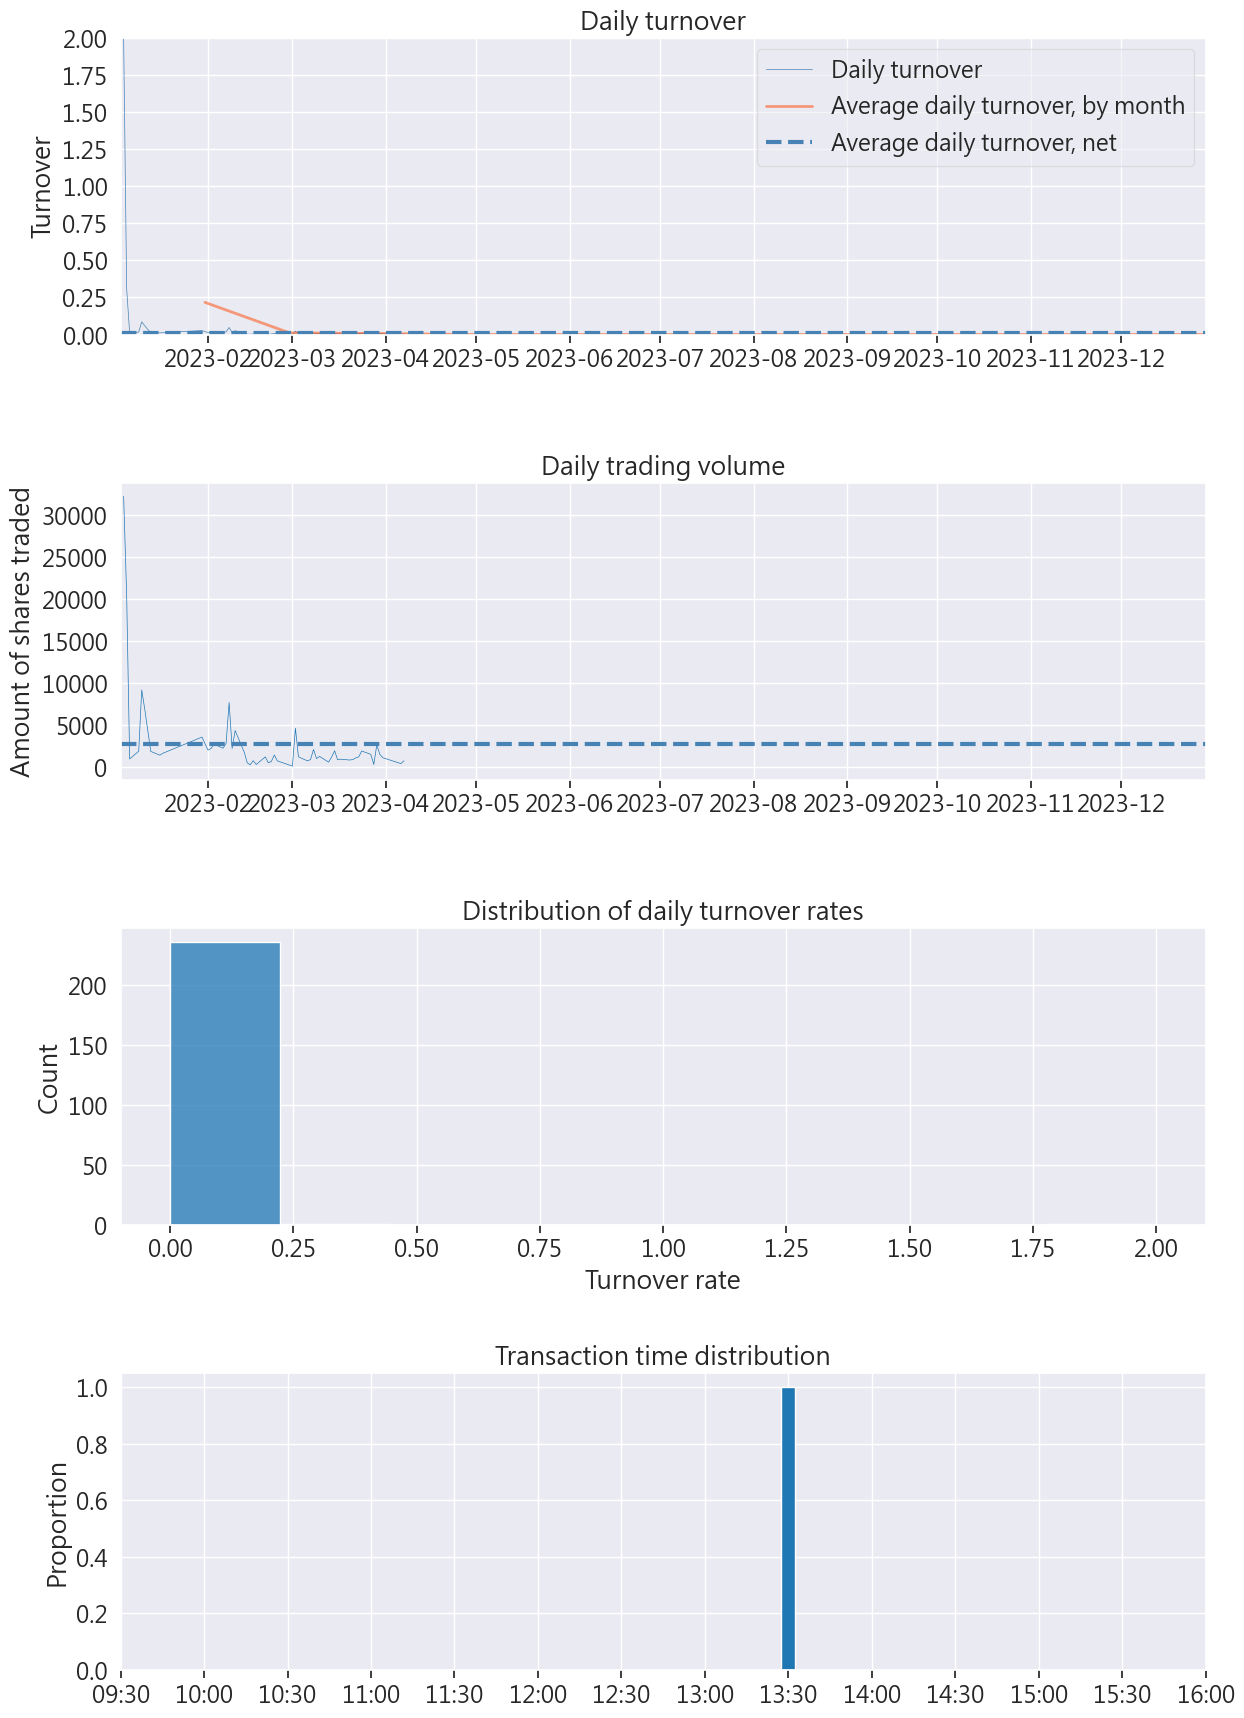

In [50]:
# 繪製 Pyfolio 中提供的所有圖表

pyfolio.tears.create_full_tear_sheet(returns=returns,
                                     positions=positions,
                                     transactions=transactions,
                                     benchmark_rets=benchmark_rets
                                    )